<a href="https://colab.research.google.com/github/NgoziOpra/Data-Projects/blob/main/UK_Crime_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To read the Open Document Spreadsheet into Pandas Dataframe
import pandas as pd
!pip install odfpy
dfname = '/content/sample_data/prc-pfa-mar2013-onwards-tables-191023.ods'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=dc20ec082d8aef63e6892bc614089884bcffd711cef4621bbba40f23d408bd50
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy


In [ ]:
xlsx = pd.ExcelFile(dfname)
for sheet_name in xlsx.sheet_names:
    df = xlsx.parse(sheet_name)
    csv_file = f"{sheet_name}.csv"
    df.to_csv(csv_file, index=False)

In [ ]:
# To install the Java and Spark Environment
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# To set the environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
#To list the files in the current directory
!ls

2012-13.csv  2015-16.csv  2018-19.csv  2021-22.csv  Cover_sheet.csv  spark-3.1.1-bin-hadoop3.2
2013-14.csv  2016-17.csv  2019-20.csv  2022-23.csv  Notes_.csv	     spark-3.1.1-bin-hadoop3.2.tgz
2014-15.csv  2017-18.csv  2020-21.csv  2023-24.csv  sample_data


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
spark = SparkSession.builder \
    .appName("crime analysis ") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.1") \
    .getOrCreate()

In [ ]:
finaldata =["/content/2012-13.csv", "/content/2013-14.csv", "/content/2014-15.csv", "/content/2015-16.csv", "/content/2016-17.csv", "/content/2017-18.csv", "/content/2018-19.csv", "/content/2019-20.csv", "/content/2020-21.csv", "/content/2021-22.csv", "/content/2022-23.csv"]
#to read csv files
def read_csv_and_create_view(finaldata, view_name):
    df = spark.read.csv(csv_file, header=True, inferSchema=True)
    df.createOrReplaceTempView(view_name)

In [ ]:
for i, csv_file in enumerate(finaldata):
    view_name = f"temp_view_{i}"
    read_csv_and_create_view(csv_file, view_name)

In [ ]:
query = " UNION ALL ".join([f"SELECT * FROM temp_view_{i}" for i in range(len(finaldata))])

merged_df = spark.sql(query)

merged_df.show()

+--------------+-----------------+-----------------+--------------------+--------------------+--------------------+------------+------------------+
|Financial Year|Financial Quarter|       Force Name| Offence Description|       Offence Group|    Offence Subgroup|Offence Code|Number of Offences|
+--------------+-----------------+-----------------+--------------------+--------------------+--------------------+------------+------------------+
|       2012/13|                1|     Action Fraud|Fraud offences re...|      Fraud offences| Fraud: Action Fraud|          AF|             20323|
|       2012/13|                1|Avon and Somerset|Abandoning child ...|Violence against ...|Violence without ...|          12|                 0|
|       2012/13|                1|Avon and Somerset|Absconding from l...|Miscellaneous cri...|Miscellaneous cri...|          80|                 1|
|       2012/13|                1|Avon and Somerset|Abuse of children...|     Sexual offences|Other sexual offe.

In [ ]:
from pyspark.sql import functions as F
missing_values = merged_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in merged_df.columns])
missing_values.show()

+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+
|Financial Year|Financial Quarter|Force Name|Offence Description|Offence Group|Offence Subgroup|Offence Code|Number of Offences|
+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+
|             0|                0|         0|                  0|            0|               0|           0|                 0|
+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+



In [ ]:
merged_df.count()

252522

In [ ]:
merged_df.columns

['Financial Year',
 'Financial Quarter',
 'Force Name',
 'Offence Description',
 'Offence Group',
 'Offence Subgroup',
 'Offence Code',
 'Number of Offences']

In [ ]:
merged_df.printSchema()

root
 |-- Financial Year: string (nullable = true)
 |-- Financial Quarter: integer (nullable = true)
 |-- Force Name: string (nullable = true)
 |-- Offence Description: string (nullable = true)
 |-- Offence Group: string (nullable = true)
 |-- Offence Subgroup: string (nullable = true)
 |-- Offence Code: string (nullable = true)
 |-- Number of Offences: integer (nullable = true)



In [ ]:
from google.colab import data_table
pandas_df = merged_df.toPandas()

pandas_df.to_csv('/content/crime_data.csv', index=False)
data_table.DataTable(pandas_df, include_index=False)
from google.colab import files


In [ ]:

import numpy as np
file_path = '/content/crime_data.csv'
df = pd.read_csv(file_path)

def identify_outliers_z_score(dataframe, threshold=3):
    outliers = {}
    for col in dataframe.columns:
        if dataframe[col].dtype.kind in 'biufc':  # Only for numerical columns
            mean = dataframe[col].mean()
            std = dataframe[col].std()
            z_scores = np.abs((dataframe[col] - mean) / std)
            outliers[col] = dataframe[z_scores > threshold]
    return outliers

outlier_results = identify_outliers_z_score(df)

outlier_entries = {col: outlier_results[col].head() for col in outlier_results}
outlier_entries

{'Financial Quarter': Empty DataFrame
 Columns: [Financial Year, Financial Quarter, Force Name, Offence Description, Offence Group, Offence Subgroup, Offence Code, Number of Offences]
 Index: [],
 'Number of Offences':      Financial Year  Financial Quarter                 Force Name  \
 0           2012/13                  1               Action Fraud   
 771         2012/13                  1                      CIFAS   
 2004        2012/13                  1  Financial Fraud Action UK   
 3865        2012/13                  1        Metropolitan Police   
 3867        2012/13                  1        Metropolitan Police   
 
                                     Offence Description  \
 0               Fraud offences recorded by Action Fraud   
 771                    Fraud offences recorded by CIFAS   
 2004  Fraud offences recorded by Financial Fraud Act...   
 3865                                Assault with injury   
 3867                             Assault without injury   


In [ ]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('/content/crime_data.csv')

# For numeric columns, replace negative values with 0
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    # Replace negative values with 0
    df[col] = np.where(df[col] < 0, 0, df[col])

    # Replace high values with a mean value integer
    mean_val_int = int(df[col].mean())
    df[col] = np.where(df[col] > df[col].quantile(0.95), mean_val_int, df[col])

# Print the DataFrame
print(df)


       Financial Year  Financial Quarter         Force Name  \
0             2012/13                  1       Action Fraud   
1             2012/13                  1  Avon and Somerset   
2             2012/13                  1  Avon and Somerset   
3             2012/13                  1  Avon and Somerset   
4             2012/13                  1  Avon and Somerset   
...               ...                ...                ...   
252517        2022/23                  3              CIFAS   
252518        2022/23                  3         UK Finance   
252519        2022/23                  4       Action Fraud   
252520        2022/23                  4              CIFAS   
252521        2022/23                  4         UK Finance   

                                      Offence Description  \
0                 Fraud offences recorded by Action Fraud   
1        Abandoning child under two years (outcomes only)   
2                          Absconding from lawful custody   

In [ ]:
a = df.sort_values('Number of Offences')[['Number of Offences']]
print(a)

        Number of Offences
126260                   0
108179                   0
108178                   0
108174                   0
108173                   0
...                    ...
99278                  998
111894                 998
192627                 998
133985                 998
197259                 998

[252522 rows x 1 columns]


In [ ]:
final_data = '/content/final_data.csv'
df.to_csv(final_data, index=False)

In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("crimedata").getOrCreate()

# Read data into a Spark DataFrame
spark_df = spark.read.csv(final_data, header=True, inferSchema=True)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()

# Save Pandas DataFrame to CSV
pandas_df.to_csv('/content/final_data.csv', index=False)

# Display the DataTable
from google.colab import data_table
data_table.DataTable(pandas_df, include_index=False)




In [ ]:
original_data = pd.read_csv('/content/crime_data.csv')
# Assuming original_data is your original DataFrame before imputation
print("Summary Statistics Before Imputation:")
print(original_data.describe())

Newdf = pd.read_csv('/content/final_data.csv')
print("\nSummary Statistics After Imputation:")
print(Newdf.describe())

Summary Statistics Before Imputation:
       Financial Quarter  Number of Offences
count      252522.000000       252522.000000
mean            2.500012          229.020588
std             1.118033         1709.368254
min             1.000000         -268.000000
25%             2.000000            0.000000
50%             3.000000            9.000000
75%             3.750000           82.000000
max             4.000000       132693.000000

Summary Statistics After Imputation:
       Financial Quarter  Number of Offences
count      252522.000000       252522.000000
mean            2.500012           83.955485
std             1.118033          165.220855
min             1.000000            0.000000
25%             2.000000            0.000000
50%             3.000000            9.000000
75%             3.750000           82.000000
max             4.000000          998.000000


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import Row
spark = SparkSession.builder \
    .appName("Excel Merge Example") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.1") \
    .getOrCreate()
Newdf1 = pd.read_csv('/content/final_data.csv')
Crimedf = spark.createDataFrame(Newdf1)
Crimedf.createOrReplaceTempView("Crimedata")

/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
Crimedf.show()

+--------------+-----------------+-----------------+--------------------+--------------------+--------------------+------------+------------------+
|Financial Year|Financial Quarter|       Force Name| Offence Description|       Offence Group|    Offence Subgroup|Offence Code|Number of Offences|
+--------------+-----------------+-----------------+--------------------+--------------------+--------------------+------------+------------------+
|       2012/13|                1|     Action Fraud|Fraud offences re...|      Fraud offences| Fraud: Action Fraud|          AF|               229|
|       2012/13|                1|Avon and Somerset|Abandoning child ...|Violence against ...|Violence without ...|          12|                 0|
|       2012/13|                1|Avon and Somerset|Absconding from l...|Miscellaneous cri...|Miscellaneous cri...|          80|                 1|
|       2012/13|                1|Avon and Somerset|Abuse of children...|     Sexual offences|Other sexual offe.

In [ ]:
#To find out the total number of offences by their force name
df2 = spark.sql("""
    SELECT `Offence Group` as OffGr, SUM(`Number of Offences`) as total_offences
    FROM crimedata
    GROUP BY `OffGr`
    ORDER BY total_offences DESC
    LIMIT 7
""")
df2.show()

+--------------------+--------------+
|               OffGr|total_offences|
+--------------------+--------------+
|      Theft offences|       7909152|
|Violence against ...|       3993892|
|Criminal damage a...|       3332740|
|Public order offe...|       1481212|
|     Sexual offences|       1373542|
|       Drug offences|       1335521|
|Miscellaneous cri...|        926422|
+--------------------+--------------+



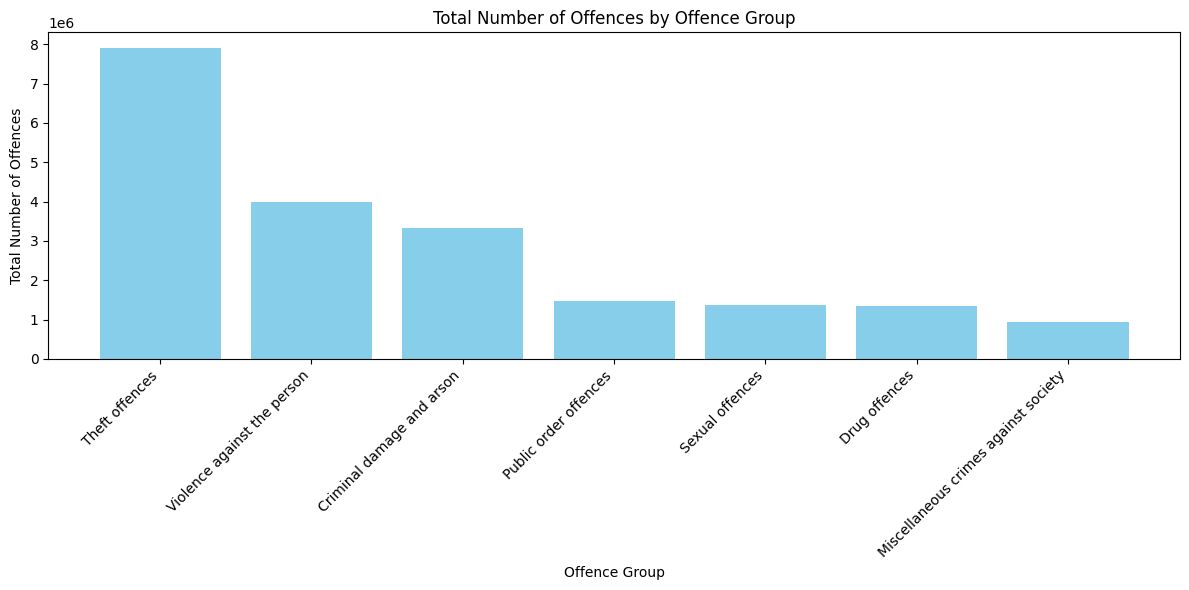

In [ ]:
import matplotlib.pyplot as plt

# Coverting the Spark DataFrame to Pandas
df2_pandas = df2.toPandas()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df2_pandas['OffGr'], df2_pandas['total_offences'], color='skyblue')
plt.xlabel('Offence Group')
plt.ylabel('Total Number of Offences')
plt.title('Total Number of Offences by Offence Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# To show the rate of offence over a period of ten years
Fyear = spark.sql("""
SELECT `Financial Year` as Fyear, SUM(`Number of Offences`) as TotalOffences
FROM Crimedata
GROUP BY `Fyear`
ORDER BY TotalOffences DESC
""")
Fyear.show()

+-------+-------------+
|  Fyear|TotalOffences|
+-------+-------------+
|2022/23|      2207918|
|2021/22|      2165412|
|2019/20|      2096673|
|2020/21|      2069646|
|2018/19|      2048477|
|2017/18|      1969940|
|2016/17|      1818309|
|2015/16|      1762459|
|2014/15|      1716097|
|2012/13|      1689247|
|2013/14|      1656429|
+-------+-------------+



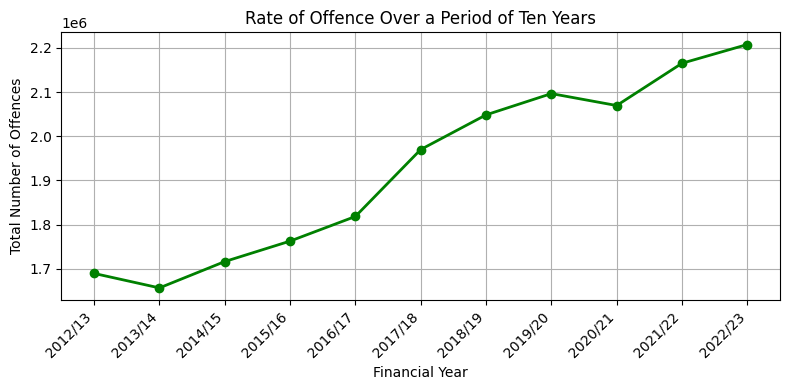

In [ ]:
import matplotlib.pyplot as plt

# Assuming Fyear is your Spark DataFrame
Fyear_pandas = Fyear.toPandas()

# Sort the DataFrame by 'Fyear' in ascending order
Fyear_pandas.sort_values(by='Fyear', inplace=True)

# Plotting the line chart
plt.figure(figsize=(8, 4))
plt.plot(Fyear_pandas['Fyear'], Fyear_pandas['TotalOffences'], marker='o', color='green', linestyle='-', linewidth=2)
plt.xlabel('Financial Year')
plt.ylabel('Total Number of Offences')
plt.title('Rate of Offence Over a Period of Ten Years')
plt.xticks(rotation=45, ha='right')
plt.grid(True)  # Adding grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

query1 = """
SELECT `Financial Quarter`, SUM(`Number of Offences`) as TotalOffences
FROM Crimedata
GROUP BY  `Financial Quarter`
ORDER BY  TotalOffences DESC
"""

Fquarter = spark.sql(query1)
Fquarter.show()

+-----------------+-------------+
|Financial Quarter|TotalOffences|
+-----------------+-------------+
|                2|      5338669|
|                3|      5327042|
|                4|      5276353|
|                1|      5258543|
+-----------------+-------------+



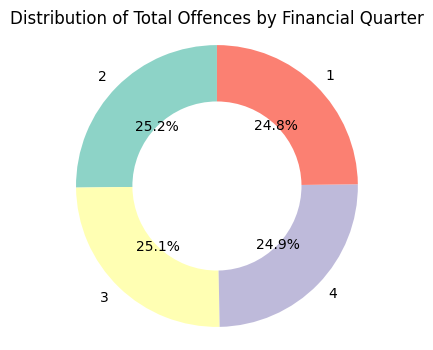

In [ ]:
import matplotlib.pyplot as plt

# Assuming Fquarter is your Spark DataFrame
Fquarter_pandas = Fquarter.toPandas()

# Use a colorful palette for the pie chart
colors = plt.cm.Set3.colors

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(Fquarter_pandas['TotalOffences'], labels=Fquarter_pandas['Financial Quarter'], autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.4))
plt.title('Distribution of Total Offences by Financial Quarter')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


In [ ]:
#To find out the total number of offences by their force name
F_name = spark.sql("""
    SELECT `Force Name` as Forcename, SUM(`Number of Offences`) as total_offences
    FROM crimedata
    GROUP BY `Forcename`
    ORDER BY total_offences DESC
    LIMIT 10
""")
F_name.show()

+-------------------+--------------+
|          Forcename|total_offences|
+-------------------+--------------+
|Metropolitan Police|        946189|
|     West Yorkshire|        796082|
| Greater Manchester|        788480|
|      West Midlands|        750132|
|      Thames Valley|        637556|
|          Hampshire|        603982|
|               Kent|        597973|
|              Essex|        585873|
|             Sussex|        581369|
|  Avon and Somerset|        573275|
+-------------------+--------------+



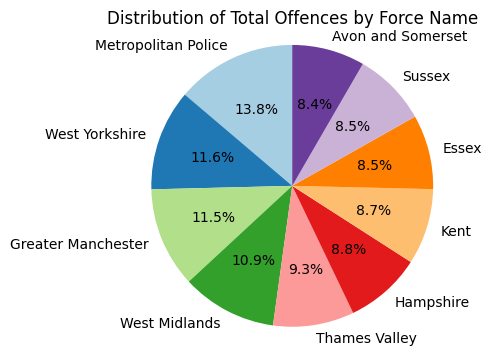

In [ ]:
import matplotlib.pyplot as plt

# Assuming F_name is your Spark DataFrame
F_name_pandas = F_name.toPandas()

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(F_name_pandas['total_offences'], labels=F_name_pandas['Forcename'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Total Offences by Force Name')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


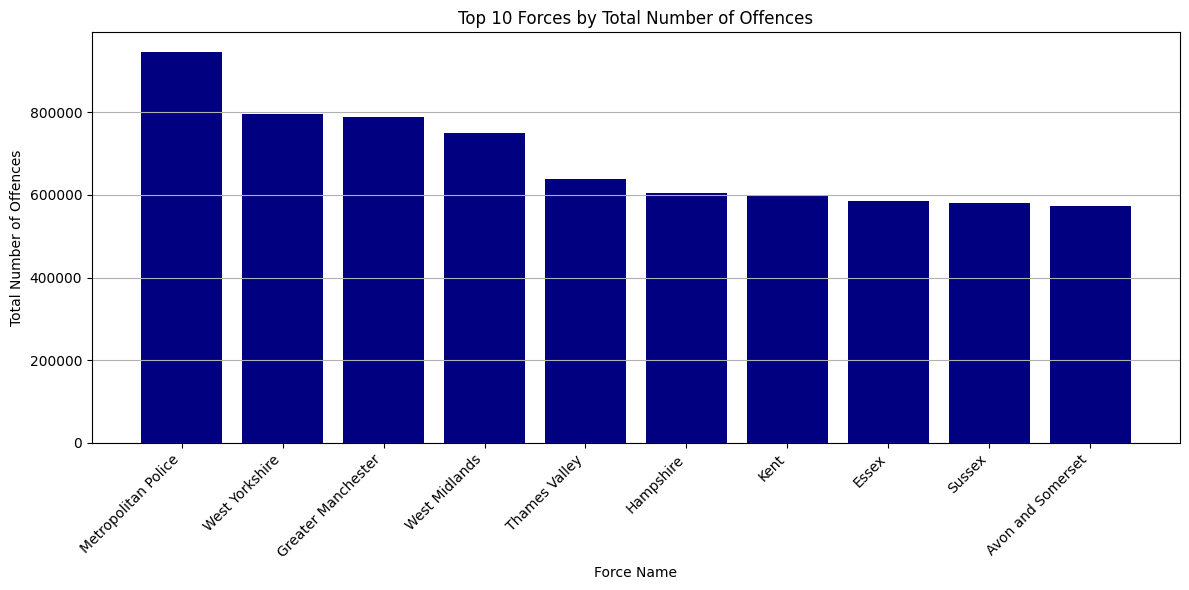

In [ ]:
import matplotlib.pyplot as plt

# Assuming F_name is your Spark DataFrame
F_name_pandas = F_name.toPandas()

# Plotting the bar chart with navy blue color
plt.figure(figsize=(12, 6))
plt.bar(F_name_pandas['Forcename'], F_name_pandas['total_offences'], color='navy')
plt.xlabel('Force Name')
plt.ylabel('Total Number of Offences')
plt.title('Top 10 Forces by Total Number of Offences')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')  # Adding horizontal grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
query = """
SELECT `Financial Year`, `Financial Quarter`, SUM(`Number of Offences`) as TotalOffences
FROM Crimedata
GROUP BY `Financial Year`, `Financial Quarter`
ORDER BY `Financial Year`, TotalOffences DESC
"""

max_offences_per_year = spark.sql(query)
max_offences_per_year.show()

+--------------+-----------------+-------------+
|Financial Year|Financial Quarter|TotalOffences|
+--------------+-----------------+-------------+
|       2012/13|                2|       429492|
|       2012/13|                1|       425207|
|       2012/13|                3|       422558|
|       2012/13|                4|       411990|
|       2013/14|                3|       420762|
|       2013/14|                2|       414705|
|       2013/14|                4|       411931|
|       2013/14|                1|       409031|
|       2014/15|                4|       432114|
|       2014/15|                3|       431420|
|       2014/15|                2|       430086|
|       2014/15|                1|       422477|
|       2015/16|                3|       444775|
|       2015/16|                1|       441373|
|       2015/16|                4|       440351|
|       2015/16|                2|       435960|
|       2016/17|                4|       457731|
|       2016/17|    

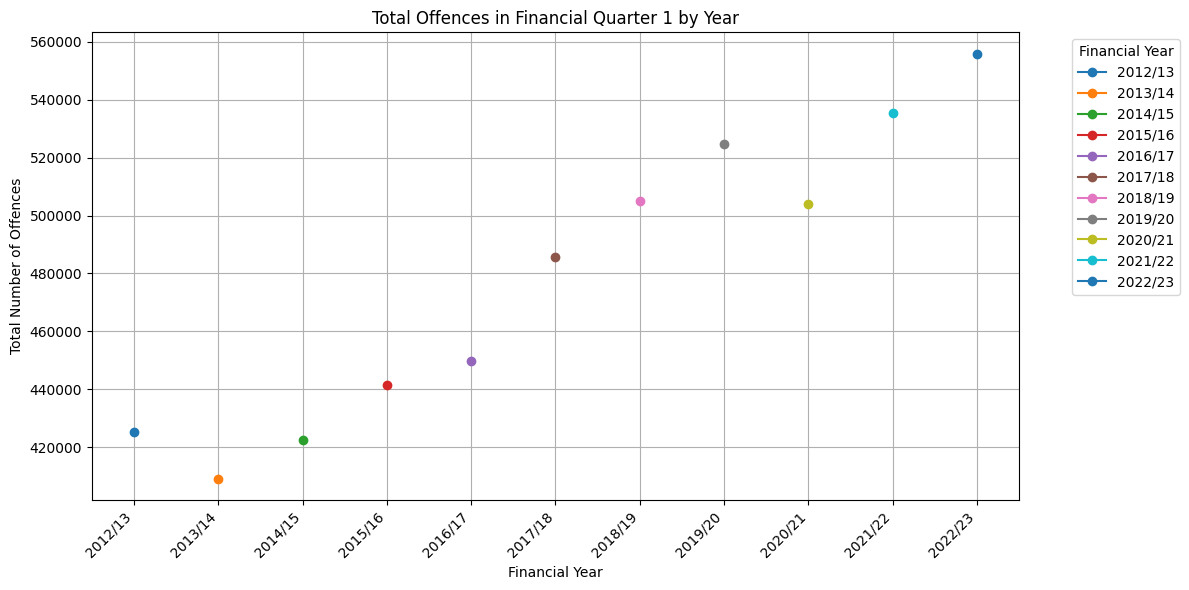

In [ ]:
import matplotlib.pyplot as plt

# Assuming max_offences_per_year is your Spark DataFrame
max_offences_per_year_pandas = max_offences_per_year.toPandas()

# Filter data for only Financial Quarter 1
max_offences_q1_pandas = max_offences_per_year_pandas[max_offences_per_year_pandas['Financial Quarter'] == 1]

# Creating a line chart
plt.figure(figsize=(12, 6))

# Iterate through each financial year to plot separate lines
for year in max_offences_q1_pandas['Financial Year'].unique():
    year_data = max_offences_q1_pandas[max_offences_q1_pandas['Financial Year'] == year]
    plt.plot(year_data['Financial Year'], year_data['TotalOffences'], label=str(year), marker='o')

plt.xlabel('Financial Year')
plt.ylabel('Total Number of Offences')
plt.title('Total Offences in Financial Quarter 1 by Year')
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation for better readability
plt.grid(True)  # Add grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


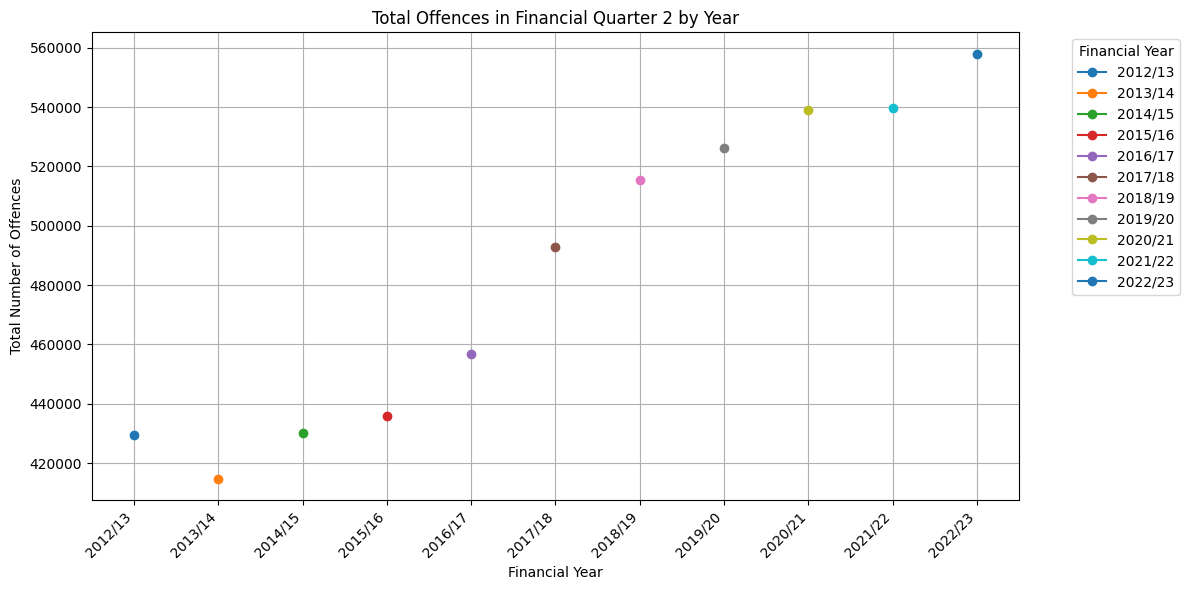

In [ ]:
import matplotlib.pyplot as plt

# Assuming max_offences_per_year is your Spark DataFrame
max_offences_per_year_pandas = max_offences_per_year.toPandas()

# Filter data for only Financial Quarter 2
max_offences_q2_pandas = max_offences_per_year_pandas[max_offences_per_year_pandas['Financial Quarter'] == 2]

# Create a line chart
plt.figure(figsize=(12, 6))

# Iterate through each financial year to plot separate lines
for year in max_offences_q2_pandas['Financial Year'].unique():
    year_data = max_offences_q2_pandas[max_offences_q2_pandas['Financial Year'] == year]
    plt.plot(year_data['Financial Year'], year_data['TotalOffences'], label=str(year), marker='o')

plt.xlabel('Financial Year')
plt.ylabel('Total Number of Offences')
plt.title('Total Offences in Financial Quarter 2 by Year')
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation for better readability
plt.grid(True)  # Add grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


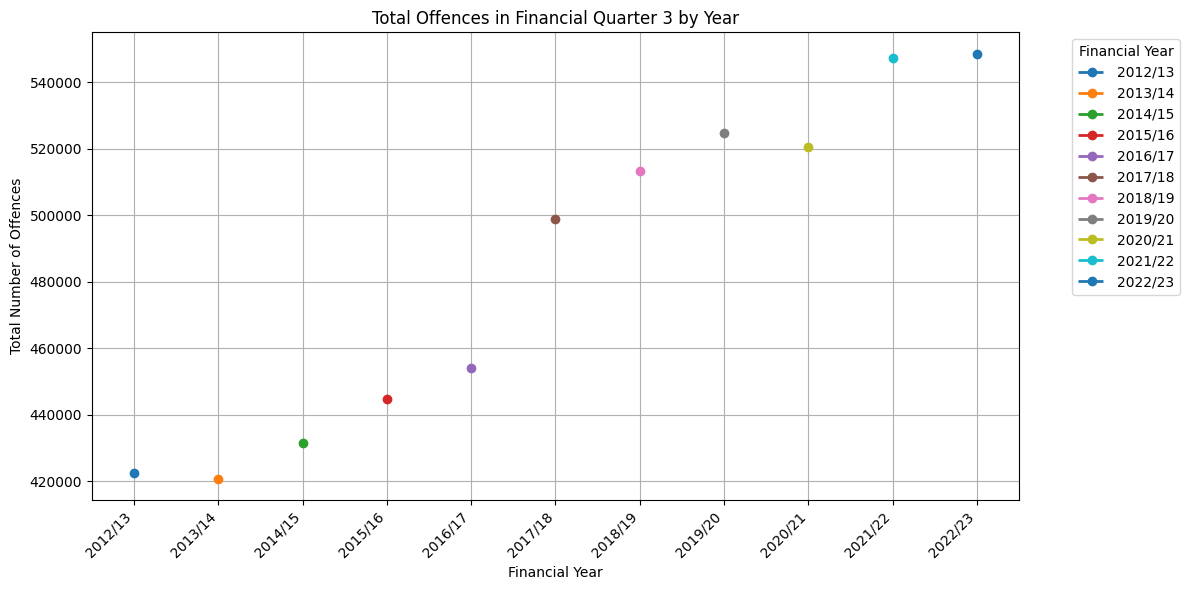

In [ ]:
import matplotlib.pyplot as plt

# Assuming max_offences_per_year is your Spark DataFrame
max_offences_per_year_pandas = max_offences_per_year.toPandas()

# Filter data for only Financial Quarter 3
max_offences_q3_pandas = max_offences_per_year_pandas[max_offences_per_year_pandas['Financial Quarter'] == 3]

# Create a line chart
plt.figure(figsize=(12, 6))

# Iterate through each financial year to plot separate lines
for year in max_offences_q3_pandas['Financial Year'].unique():
    year_data = max_offences_q3_pandas[max_offences_q3_pandas['Financial Year'] == year]
    plt.plot(year_data['Financial Year'], year_data['TotalOffences'], label=str(year), marker='o', linestyle='--', linewidth=2)

plt.xlabel('Financial Year')
plt.ylabel('Total Number of Offences')
plt.title('Total Offences in Financial Quarter 3 by Year')
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation for better readability
plt.grid(True)  # Add grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


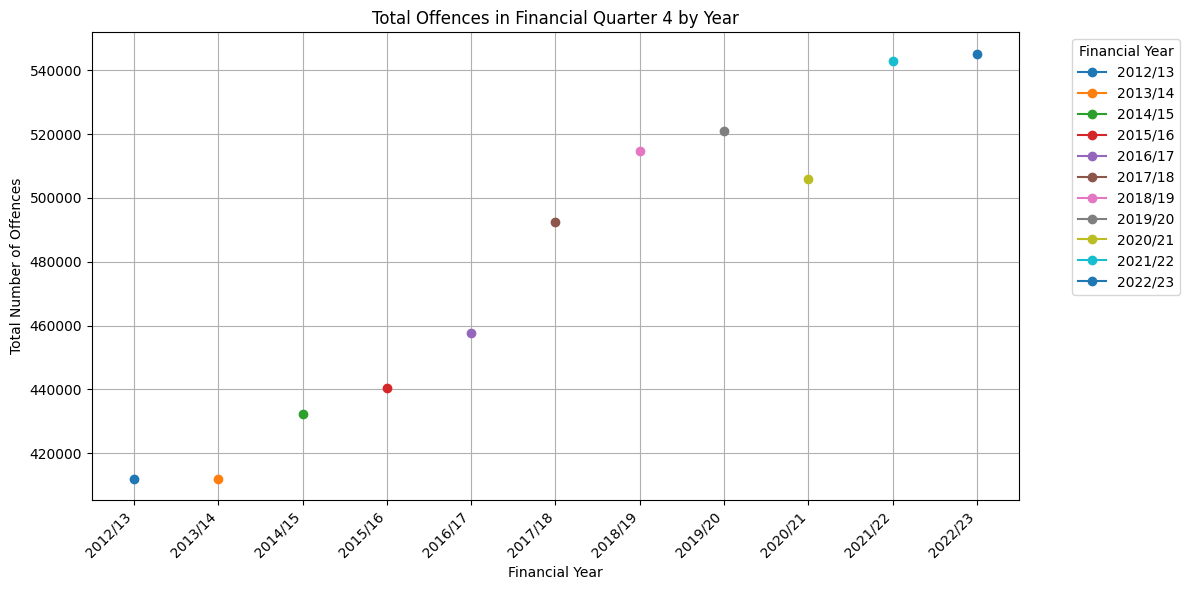

In [ ]:
import matplotlib.pyplot as plt

# Assuming max_offences_per_year is your Spark DataFrame
max_offences_per_year_pandas = max_offences_per_year.toPandas()

# Filter data for only Financial Quarter 4
max_offences_q4_pandas = max_offences_per_year_pandas[max_offences_per_year_pandas['Financial Quarter'] == 4]

# Create a line chart
plt.figure(figsize=(12, 6))

# Iterate through each financial year to plot separate lines
for year in max_offences_q4_pandas['Financial Year'].unique():
    year_data = max_offences_q4_pandas[max_offences_q4_pandas['Financial Year'] == year]
    plt.plot(year_data['Financial Year'], year_data['TotalOffences'], marker='o', label=str(year), linestyle='-')

plt.xlabel('Financial Year')
plt.ylabel('Total Number of Offences')
plt.title('Total Offences in Financial Quarter 4 by Year')
plt.legend(title='Financial Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation for better readability
plt.grid(True)  # Add grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
query = """
SELECT `Financial Quarter`, `Offence Group`, SUM(`Number of Offences`) as TotalOffences
FROM Crimedata
GROUP BY `Financial Quarter`, `Offence Group`
ORDER BY `Financial Quarter`, `Offence Group`
"""

offences_per_group_per_quarter = spark.sql(query)
offences_per_group_per_quarter.show()

+-----------------+--------------------+-------------+
|Financial Quarter|       Offence Group|TotalOffences|
+-----------------+--------------------+-------------+
|                1|Criminal damage a...|       846503|
|                1|       Drug offences|       338257|
|                1|      Fraud offences|        20966|
|                1|Miscellaneous cri...|       227816|
|                1|Possession of wea...|        99578|
|                1|Public order offe...|       372187|
|                1|             Robbery|        90510|
|                1|     Sexual offences|       335201|
|                1|      Theft offences|      1944962|
|                1|Violence against ...|       982563|
|                2|Criminal damage a...|       846781|
|                2|       Drug offences|       331200|
|                2|      Fraud offences|        20751|
|                2|Miscellaneous cri...|       228707|
|                2|Possession of wea...|       103595|
|         

<Figure size 1200x600 with 0 Axes>

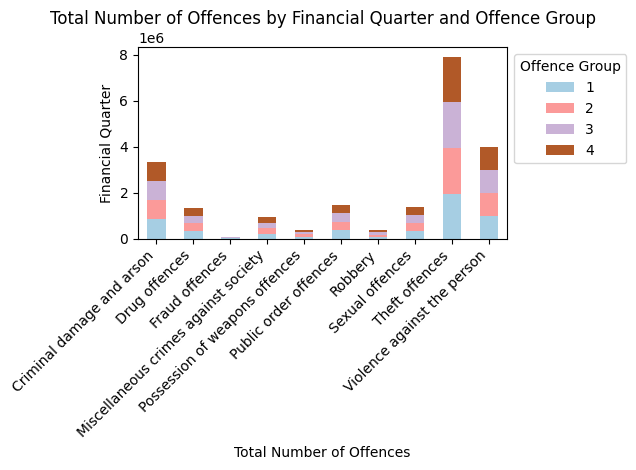

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming offences_per_group_per_quarter is your Spark DataFrame
offences_pandas = offences_per_group_per_quarter.toPandas()

# Pivot the DataFrame for better plotting
pivot_df = offences_pandas.pivot(index='Offence Group', columns='Financial Quarter', values='TotalOffences')

# Plotting the stacked column chart
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, colormap='Paired')
plt.xlabel('Total Number of Offences')
plt.ylabel('Financial Quarter')
plt.title('Total Number of Offences by Financial Quarter and Offence Group')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation for better readability
plt.legend(title='Offence Group', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, row_number
# Initialize Spark session with Hive support
from pyspark.sql import SparkSession

# Initialize a Spark session
# Hive support is enabled in the Spark session
spark = SparkSession.builder \
    .appName("Offencedata") \
    .config("spark.sql.warehouse.dir", "/path/to/your/hive/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

# Query to select the top 5 forces with the highest total number of offences
query_top_forces = """
    SELECT `Force Name`, SUM(`Number of Offences`) as TotalOffences
    FROM Crimedata
    GROUP BY `Force Name`
    ORDER BY TotalOffences DESC
    LIMIT 5
"""

# Execute the query and create a temporary view named "top_5_forces"
spark.sql(query_top_forces).createOrReplaceTempView("top_5_forces")

# Query to find the highest offence quarters for the top forces
query_highest_quarters = """
    WITH RankedQuarters AS (
        SELECT `Force Name`, `Financial Quarter`, SUM(`Number of Offences`) as TotalOffences,
        RANK() OVER (PARTITION BY `Force Name` ORDER BY SUM(`Number of Offences`) DESC) as Rank
        FROM Crimedata
        GROUP BY `Force Name`, `Financial Quarter`
    )
    SELECT `Force Name`, `Financial Quarter`, TotalOffences
    FROM RankedQuarters
    WHERE `Force Name` IN (SELECT `Force Name` FROM top_5_forces)
      AND Rank = 1
"""

# Execute the query to find the highest offence quarters
highest_offence_quarters = spark.sql(query_highest_quarters)
highest_offence_quarters.show()


+-------------------+-----------------+-------------+
|         Force Name|Financial Quarter|TotalOffences|
+-------------------+-----------------+-------------+
|      Thames Valley|                4|       164552|
| Greater Manchester|                4|       202129|
|Metropolitan Police|                3|       240317|
|      West Midlands|                2|       189973|
|     West Yorkshire|                1|       200722|
+-------------------+-----------------+-------------+



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, row_number
# Initialize Spark session with Hive support
from pyspark.sql import SparkSession

# Initialize a Spark session
# Hive support is enabled in the Spark session
spark = SparkSession.builder \
    .appName("Offencedata") \
    .config("spark.sql.warehouse.dir", "/path/to/your/hive/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

# Now you can run your queries
query_avg_offences = """
SELECT `Offence Group`, AVG(`Number of Offences`) as AverageOffences
FROM Crimedata
GROUP BY `Offence Group`
ORDER BY AverageOffences DESC
"""

avg_offences_per_group = spark.sql(query_avg_offences)
avg_offences_per_group.show()

+--------------------+------------------+
|       Offence Group|   AverageOffences|
+--------------------+------------------+
|Criminal damage a...| 233.7780583613917|
|Public order offe...|175.33285984848484|
|       Drug offences| 172.4588068181818|
|      Theft offences| 149.2968891573543|
|             Robbery| 97.43930785123968|
|Violence against ...|  66.5404684948852|
|      Fraud offences|46.034415584415584|
|Possession of wea...| 34.43078512396694|
|     Sexual offences|31.216863636363637|
|Miscellaneous cri...|19.281177156177158|
+--------------------+------------------+



In [ ]:
data_rdd1 = '/content/final_data.csv'
sql_df = spark.read.csv(data_rdd1, header=True, inferSchema=True)
sql_df.createOrReplaceTempView("Offences")

In [ ]:
from pyspark.sql import SparkSession

# Initializing Spark session
spark = SparkSession.builder.appName("OffenceTrendAnalysis").getOrCreate()

# Loading the data
df = spark.read.csv(data_rdd1, header=True, inferSchema=True)

# Filtering forthe offence violence against the person
specific_offence_type = "Violence against the person"
filtered_df = df.filter(df["Offence Group"] == specific_offence_type)

# Mapping the data to create key-value pairs
mapped_data = filtered_df.rdd.map(lambda row: ((row["Offence Group"], row["Financial Year"]), 1))

# Using the reduceByKey to sum up the counts for each key
reduced_data = mapped_data.reduceByKey(lambda a, b: a + b)

# Collecting the results
trend_data = reduced_data.collect()

# Print the results
for key, count in trend_data:
    print(f"Offences: {key[0]}, Year: {key[1]}, Count: {count}")



Offences: Violence against the person, Year: 2012/13, Count: 6336
Offences: Violence against the person, Year: 2017/18, Count: 5456
Offences: Violence against the person, Year: 2019/20, Count: 5462
Offences: Violence against the person, Year: 2021/22, Count: 5808
Offences: Violence against the person, Year: 2013/14, Count: 4752
Offences: Violence against the person, Year: 2014/15, Count: 4928
Offences: Violence against the person, Year: 2015/16, Count: 5104
Offences: Violence against the person, Year: 2016/17, Count: 5104
Offences: Violence against the person, Year: 2018/19, Count: 5456
Offences: Violence against the person, Year: 2020/21, Count: 5808
Offences: Violence against the person, Year: 2022/23, Count: 5808


In [ ]:
Crime_data = pd.read_csv(data_rdd1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial year
yearly_totals = drug_offences.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# We need to convert 'Financial Year' into a numerical format for regression analysis
# Assuming '2020/21' as 2020, '2021/22' as 2021, etc.
yearly_totals['Year'] = yearly_totals['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Preparing the data for linear regression
X = yearly_totals['Year'].values.reshape(-1, 1)  # Features (Year)
y = yearly_totals['Number of Offences'].values    # Target variable (Total Number of Drug Offences)

# Creating and training the Linear Regression model
model_lr= LinearRegression()
model_lr.fit(X, y)

# Predicting for the next decade
future_years = np.array([year for year in range(2024, 2034)]).reshape(-1, 1)
predictions = model_lr.predict(future_years)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions1 = mean_squared_error(y, model_lr.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions1}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
total_predicted_offences, predictions  # Returning total and yearly predictions


Mean Squared Error for the predicted data: 105361638.37933892


(1188079.2272727266,
 array([119826.51818182, 119600.16363636, 119373.80909091, 119147.45454545,
        118921.1       , 118694.74545455, 118468.39090909, 118242.03636364,
        118015.68181818, 117789.32727273]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial year
yearly_totals = drug_offences.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# We need to convert 'Financial Year' into a numerical format for regression analysis
# Assuming '2020/21' as 2020, '2021/22' as 2021, etc.
yearly_totals['Year'] = yearly_totals['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Preparing the data for random forest regression
X = yearly_totals['Year'].values.reshape(-1, 1)  # Features (Year)
y = yearly_totals['Number of Offences'].values    # Target variable (Total Number of Drug Offences)

# Creating and training the RandomForestRegressor model
model_random = RandomForestRegressor()
model_random.fit(X, y)

# Predicting for the next decade
future_years = np.array([year for year in range(2024, 2034)]).reshape(-1, 1)
predictions = model_random.predict(future_years)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions2 = mean_squared_error(y, model_random.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions2}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
total_predicted_offences, predictions  # Returning total and yearly predictions


Mean Squared Error for the predicted data: 5733858.7195636295


(1236140.6,
 array([123614.06, 123614.06, 123614.06, 123614.06, 123614.06, 123614.06,
        123614.06, 123614.06, 123614.06, 123614.06]))

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial year
yearly_totals = drug_offences.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# We need to convert 'Financial Year' into a numerical format for regression analysis
# Assuming '2020/21' as 2020, '2021/22' as 2021, etc.
yearly_totals['Year'] = yearly_totals['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Preparing the data for support vector regression
X = yearly_totals['Year'].values.reshape(-1, 1)  # Features (Year)
y = yearly_totals['Number of Offences'].values    # Target variable (Total Number of Drug Offences)

# Creating and training the Support Vector Regression (SVR) model
model_svr = SVR()
model_svr.fit(X, y)

# Predicting for the next decade
future_years = np.array([year for year in range(2024, 2034)]).reshape(-1, 1)
predictions = model_svr.predict(future_years)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions3 = mean_squared_error(y, model_svr.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions3}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
total_predicted_offences, predictions  # Returning total and yearly predictions


Mean Squared Error for the predicted data: 109018942.28514495


(1231899.3748510836,
 array([123189.61512077, 123189.73153133, 123189.86900152, 123189.96481132,
        123190.012733  , 123190.03103938, 123190.03653198, 123190.03784571,
        123190.03809839, 123190.03813768]))

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'Crime_data' is your DataFrame containing crime data
# Make sure to replace 'Crime_data' with your actual DataFrame name

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial year
yearly_totals = drug_offences.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# We need to convert 'Financial Year' into a numerical format for regression analysis
# Assuming '2020/21' as 2020, '2021/22' as 2021, etc.
yearly_totals['Year'] = yearly_totals['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Preparing the data for support vector regression
X = yearly_totals['Year'].values.reshape(-1, 1)  # Features (Year)
y = yearly_totals['Number of Offences'].values    # Target variable (Total Number of Drug Offences)

# Creating and training the Support Vector Regression (SVR) model with RBF kernel
model_svr_rbf = SVR(kernel='rbf')
model_svr_rbf.fit(X, y)

# Predicting for the next decade
future_years = np.array([year for year in range(2024, 2034)]).reshape(-1, 1)
predictions_rbf = model_svr_rbf.predict(future_years)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions_rbf = mean_squared_error(y, model_svr_rbf.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data (RBF): {mse_predictions_rbf}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences_rbf = predictions_rbf.sum()
total_predicted_offences_rbf, predictions_rbf  # Returning total and yearly predictions


Mean Squared Error for the predicted data (RBF): 109018942.28514495


(1231899.3748510836,
 array([123189.61512077, 123189.73153133, 123189.86900152, 123189.96481132,
        123190.012733  , 123190.03103938, 123190.03653198, 123190.03784571,
        123190.03809839, 123190.03813768]))

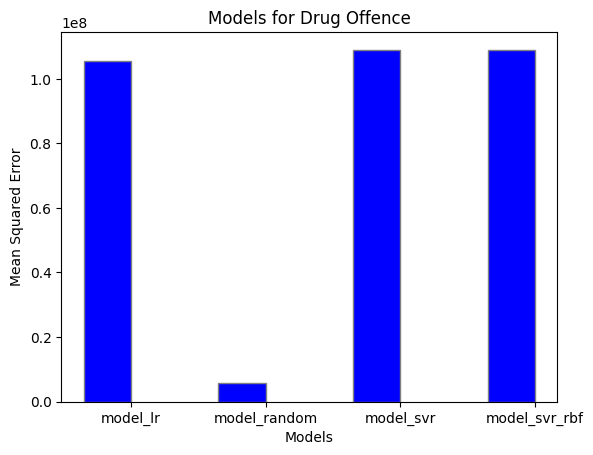

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Three models: Linear, Random Forest Regression (RFR), and Support Vector Regression (SVR)
models = ['model_lr', 'model_random', 'model_svr', 'model_svr_rbf']

# MSE predictions
mse_predictions = [mse_predictions1, mse_predictions2, mse_predictions3, mse_predictions_rbf]

# Bar chart
width = 0.35  # Width of the bars
r = np.arange(len(models))  # Generating evenly spaced values

plt.bar(r, mse_predictions, color='blue', width=width, edgecolor='grey', capsize=7)

plt.xlabel("Models")
plt.ylabel("Mean Squared Error")
plt.title("Models for Drug Offence")

# Adjusting the x-axis ticks
plt.xticks(r + width/2, models)

plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial quarter
yearly_totals = drug_offences.groupby('Financial Quarter')['Number of Offences'].sum().reset_index()

# Preparing the data for linear regression
X = yearly_totals['Financial Quarter'].values.reshape(-1, 1)  # Features (Financial Quarter)
y = yearly_totals['Number of Offences'].values  # Target variable (Total Number of Drug Offences)

# Creating and training the Linear Regression model
model_lr1 = LinearRegression()
model_lr1.fit(X, y)

# Create future financial quarters for prediction
future_quarters = np.array([1, 2, 3, 4]).reshape(-1, 1)

# Predicting for the future quarters
predictions = model_lr1.predict(future_quarters)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions_lr = mean_squared_error(y, model_lr1.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions1}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
print(f"Total Predicted Offences for the Next Quarters: {total_predicted_offences}")
print("Yearly Predictions:")
for quarter, prediction in zip(future_quarters.flatten(), predictions):
    print(f"Quarter: {quarter}, Predicted Offences: {prediction}")


Mean Squared Error for the predicted data: 5168889.074999943
Total Predicted Offences for the Next Quarters: 1335521.0
Yearly Predictions:
Quarter: 1, Predicted Offences: 336608.3
Quarter: 2, Predicted Offences: 334789.6
Quarter: 3, Predicted Offences: 332970.9
Quarter: 4, Predicted Offences: 331152.2


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial quarter
yearly_totals = drug_offences.groupby('Financial Quarter')['Number of Offences'].sum().reset_index()

# Preparing the data for Random Forest Regression
X = yearly_totals['Financial Quarter'].values.reshape(-1, 1)  # Features (Financial Quarter)
y = yearly_totals['Number of Offences'].values  # Target variable (Total Number of Drug Offences)

# Creating and training the Random Forest Regression model
model_rf1 = RandomForestRegressor()
model_rf1.fit(X, y)

# Create future financial quarters for prediction
future_quarters = np.array([1, 2, 3, 4]).reshape(-1, 1)

# Predicting for the future quarters
predictions = model_rf1.predict(future_quarters)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions_rf = mean_squared_error(y, model_rf1.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions_rf}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
print(f"Total Predicted Offences for the Next Quarters: {total_predicted_offences}")
print("Yearly Predictions:")
for quarter, prediction in zip(future_quarters.flatten(), predictions):
    print(f"Quarter: {quarter}, Predicted Offences: {prediction}")


Mean Squared Error for the predicted data: 2383001.102624956
Total Predicted Offences for the Next Quarters: 1335363.07
Yearly Predictions:
Quarter: 1, Predicted Offences: 336450.71
Quarter: 2, Predicted Offences: 333133.92
Quarter: 3, Predicted Offences: 333945.76
Quarter: 4, Predicted Offences: 331832.68


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial quarter
yearly_totals = drug_offences.groupby('Financial Quarter')['Number of Offences'].sum().reset_index()

# Preparing the data for Support Vector Regression (RBF Kernel)
X = yearly_totals['Financial Quarter'].values.reshape(-1, 1)  # Features (Financial Quarter)
y = yearly_totals['Number of Offences'].values  # Target variable (Total Number of Drug Offences)

# Creating and training the Support Vector Regression (SVR) model with RBF kernel
model_rbf = SVR(kernel='rbf')
model_rbf.fit(X, y)

# Create future financial quarters for prediction
future_quarters = np.array([1, 2, 3, 4]).reshape(-1, 1)

# Predicting for the future quarters
predictions = model_rbf.predict(future_quarters)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions_rbf = mean_squared_error(y, model_rbf.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions_rbf}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
print(f"Total Predicted Offences for the Next Quarters: {total_predicted_offences}")
print("Yearly Predictions:")
for quarter, prediction in zip(future_quarters.flatten(), predictions):
    print(f"Quarter: {quarter}, Predicted Offences: {prediction}")


Mean Squared Error for the predicted data: 9761030.287202172
Total Predicted Offences for the Next Quarters: 1332808.0
Yearly Predictions:
Quarter: 1, Predicted Offences: 333202.59068665403
Quarter: 2, Predicted Offences: 333201.85789572424
Quarter: 3, Predicted Offences: 333202.14210427576
Quarter: 4, Predicted Offences: 333201.40931334597


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Filtering the dataset for drug offences
drug_offences = Crime_data[Crime_data['Offence Group'] == 'Drug offences']

# Aggregating the number of drug offences by financial quarter
yearly_totals = drug_offences.groupby('Financial Quarter')['Number of Offences'].sum().reset_index()

# Preparing the data for Support Vector Regression (SVR)
X = yearly_totals['Financial Quarter'].values.reshape(-1, 1)  # Features (Financial Quarter)
y = yearly_totals['Number of Offences'].values  # Target variable (Total Number of Drug Offences)

# Creating and training the Support Vector Regression (SVR) model
model_svr1 = SVR()
model_svr1.fit(X, y)

# Create future financial quarters for prediction
future_quarters = np.array([1, 2, 3, 4]).reshape(-1, 1)

# Predicting for the future quarters
predictions = model_svr1.predict(future_quarters)

# Calculate Mean Squared Error (MSE) for the predicted data
mse_predictions_svr1 = mean_squared_error(y, model_svr.predict(X))

# Print the MSE for the predicted data
print(f"Mean Squared Error for the predicted data: {mse_predictions_svr1}")

# Summing up the predictions for the total number over the next decade
total_predicted_offences = predictions.sum()
print(f"Total Predicted Offences for the Next Quarters: {total_predicted_offences}")
print("Yearly Predictions:")
for quarter, prediction in zip(future_quarters.flatten(), predictions):
    print(f"Quarter: {quarter}, Predicted Offences: {prediction}")


Mean Squared Error for the predicted data: 44399668848.45657
Total Predicted Offences for the Next Quarters: 1332808.0
Yearly Predictions:
Quarter: 1, Predicted Offences: 333202.59068665403
Quarter: 2, Predicted Offences: 333201.85789572424
Quarter: 3, Predicted Offences: 333202.14210427576
Quarter: 4, Predicted Offences: 333201.40931334597


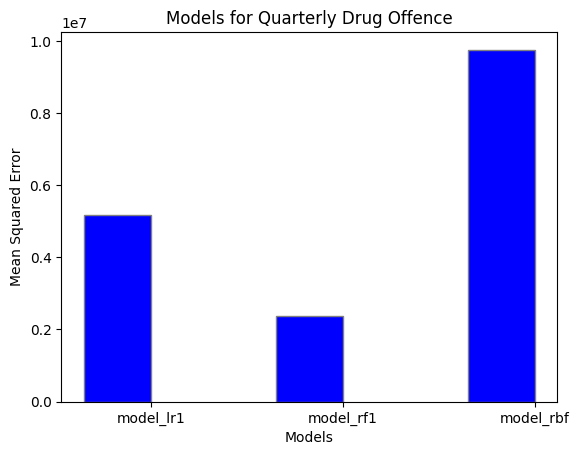

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Three models: Linear, Random Forest Regression (RFR), and Support Vector Regression (SVR)
models = ['model_lr1', 'model_rf1', 'model_rbf']

# MSE predictions
mse_predictions_quarter = [mse_predictions_lr, mse_predictions_rf, mse_predictions_rbf]

# Bar chart
width = 0.35  # Width of the bars
r = np.arange(len(models))  # Generating evenly spaced values

plt.bar(r, mse_predictions_quarter, color='blue', width=width, edgecolor='grey', capsize=7)

plt.xlabel("Models")
plt.ylabel("Mean Squared Error")
plt.title("Models for Quarterly Drug Offence")

# Adjusting the x-axis ticks
plt.xticks(r + width/2, models)

plt.show()